# Intégrer une colonne population pour créer des features relatives à celles-ci

Grâce au CSV country_population_2020 pris de Kaggle, on rejoute pour chaque ligne une données Population qui correspond au pays.

In [10]:
import pandas as pd

##### Ajout de la population dan le DataSet #####

# Charger les données
population_df = pd.read_csv('country_population_2020.csv')
covid_df = pd.read_csv('data_etl_output.csv')

# Créer un dictionnaire de mapping pour les noms de pays qui diffèrent
country_name_mapping = {
    'Burma': 'Myanmar',
    'Congo (Brazzaville)': 'Congo',
    'Congo (Kinshasa)': 'DR Congo',
    'Czechia': 'Czech Republic (Czechia)',
    'Taiwan*': 'Taiwan',
    'US': 'United States',
    'West Bank and Gaza': 'State of Palestine',
    'Kosovo': 'Kosovo',  # Kosovo n'est pas dans le fichier population
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Saint Kitts and Nevis': 'Saint Kitts & Nevis',
    'Saint Vincent and the Grenadines': 'St. Vincent & Grenadines',
    'Sao Tome and Principe': 'Sao Tome & Principe'
}

# Ajout manuel de la population du Kosovo car vide
kosovo_data = pd.DataFrame({
    'Country (or dependency)': ['Kosovo'],
    'Population (2020)': [1920079],
    'Yearly Change': [""],
    'Net Change': [""],
    'Density (P/Km²)': [""],
    'Land Area (Km²)': [""],
    'Migrants (net)': [""],
    'Fert. Rate': [""],
    'Med. Age': [""],
    'Urban Pop %': [""],
    'World Share': [""]
})

# ajoute Kosovo dans population_df
population_df = pd.concat([population_df, kosovo_data], ignore_index=True)

# Nettoyer les noms de pays dans les deux dataframes
population_df['Country'] = population_df['Country (or dependency)'].str.strip()
covid_df['Country'] = covid_df['Country'].str.strip()

# Appliquer le mapping aux noms de pays dans covid_df
covid_df['Country'] = covid_df['Country'].replace(country_name_mapping)

# Fusionner les données en gardant toutes les lignes de covid_df
final_df = pd.merge(
    covid_df,
    population_df[['Country', 'Population (2020)']],
    on='Country',
    how='left'
)

# Renommer la colonne de population
final_df.rename(columns={'Population (2020)': 'Population'}, inplace=True)

# Création de features par rapport à la population et au temps écoulé entre chaque mesure

On rajoute des colonnes pour avoir :
- Le taux d'infections, de morts, et de guéris pour 100K habitants sur une population d'un pays
- La tendance d'infection d'un pays (sur une période de 3 mois)
- La moyenne mobile de chaque pays


In [11]:
##### Ajoute les colonnes Confirmed_per_100K, ... pour apporter de nouvelles metrics à nos modèles #####

def calc_features(dataframe):
    dataframe["Confirmed_per_100K"] = dataframe["Confirmed"] / (dataframe["Population"] / 100000)
    dataframe["Deaths_per_100K"] = dataframe["Deaths"] / (dataframe["Population"] / 100000)
    dataframe["Recovered_per_100K"] = dataframe["Recovered"] / (dataframe["Population"] / 100000)
    
    ##### Calcul des tendances et moyennes mobiles #####
    for col in ['Confirmed', 'Deaths', 'Recovered']:
        dataframe[f'{col}_rolling_avg3'] = dataframe.groupby('Country')[col].transform(
            lambda x: x.rolling(3, min_periods=1).mean()
        )
        
        dataframe[f'{col}_trend'] = dataframe.groupby('Country')[col].transform(
            lambda x: x.diff().rolling(3, min_periods=1).mean().fillna(0)
        )

calc_features(final_df)

# Vérification et correction des données

On vérifie la cohérence de nos données.

## Population
Si une donnée est manquante on essaie d'affecter la valeur population d'une autre ligne avec le même pays.
Si elles sont toutes vides, on lance un message d'alerte.

## Features
Si on a recalculé les valeurs dans Population, alors on refait les features XXX_per_100K, ...

In [12]:
##### Vérification et correction des valeurs négatives #####
# Pour les principales métriques COVID
isNeg = False

for col in ['Confirmed', 'Deaths', 'Recovered']:
    if (sum(final_df[col] < 0) > 0):
        isNeg = True
    final_df.loc[final_df[col] < 0, col] = 0
    print(f"{sum(final_df[col] < 0)} valeurs négatives corrigées dans {col}")

##### Correction des populations manquantes par pays #####
# 1. Identifier les lignes où la population est manquante ou <= 800 (Pop Vatican)
missing_pop_mask = final_df['Population'].isna() | (final_df['Population'] <= 800)

# 2. Grouper par pays et remplir les trous avec la première valeur valide trouvée dans le même pays
final_df['Population'] = final_df.groupby('Country')['Population'].transform(
    lambda x: x.fillna(x[x.notna() & (x > 800)].iloc[0] if any(x[x.notna() & (x > 800)]) else x)
)

# 3. Vérifier ce qui reste sans population
still_missing = final_df['Population'].isna() | (final_df['Population'] <= 800)

if still_missing.any():
    missing_countries = final_df[still_missing]['Country'].unique()
    print(f"AVERTISSEMENT : Population toujours manquante pour {len(missing_countries)} pays :")
    print(', '.join(missing_countries))
    
    # Option 1 : Exclure ces pays des métriques par habitant
    for col in ['Confirmed_per_100K', 'Deaths_per_100K', 'Recovered_per_100K']:
        final_df.loc[still_missing, col] = 0
    
##### Recalculer les métriques après corrections #####
# Recalculer les indicateurs normalisés si la population a été modifiée
if missing_pop_mask.any() | isNeg :  # Changed from missing_pop to missing_pop_mask
    calc_features(final_df)

print("\nVérifications de qualité terminées. Données prêtes pour l'analyse.")

0 valeurs négatives corrigées dans Confirmed
0 valeurs négatives corrigées dans Deaths
0 valeurs négatives corrigées dans Recovered

Vérifications de qualité terminées. Données prêtes pour l'analyse.


# Entrainement des données

Split 80/20 pour les données au vu de la taille du dataset

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Créer des colonnes décalées pour les prédictions
for col in ['Confirmed', 'Deaths', 'Recovered']:
    final_df[f'{col}_lag1'] = final_df.groupby('Country')[col].shift(1).fillna(0)

# Encoder les pays
le = LabelEncoder()
final_df['Country_encoded'] = le.fit_transform(final_df['Country'])

# Définir les features et la target
features = [
    'Confirmed_lag1', 'Deaths_lag1', 'Recovered_lag1', 'Country_encoded',
    'Confirmed_per_100K', 'Deaths_per_100K', 'Recovered_per_100K',
    'Confirmed_rolling_avg3', 'Deaths_rolling_avg3', 'Recovered_rolling_avg3',
    'Confirmed_trend', 'Deaths_trend', 'Recovered_trend'
]
targets = ['Confirmed', 'Deaths', 'Recovered']

X = final_df[features]
y = final_df[targets]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création des modèles

Liste des modèles créé :
- RandomForestRegressor
- ...

In [14]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
model.fit(X_train[features], y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

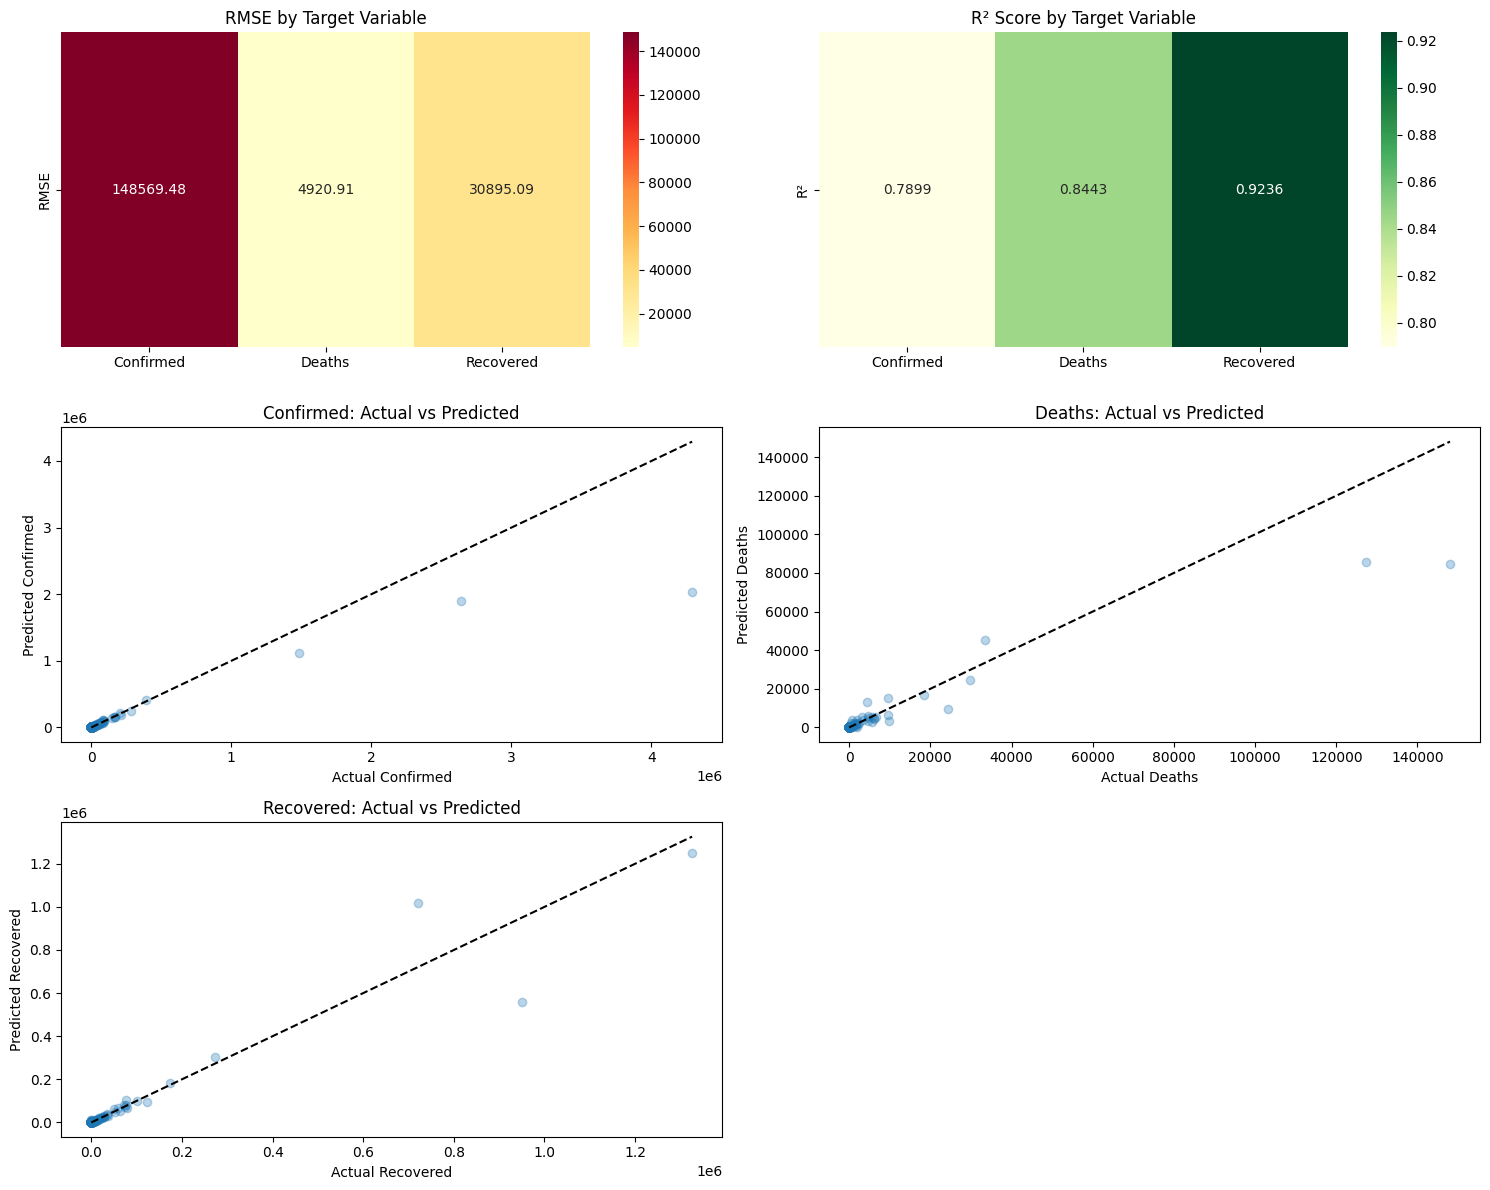

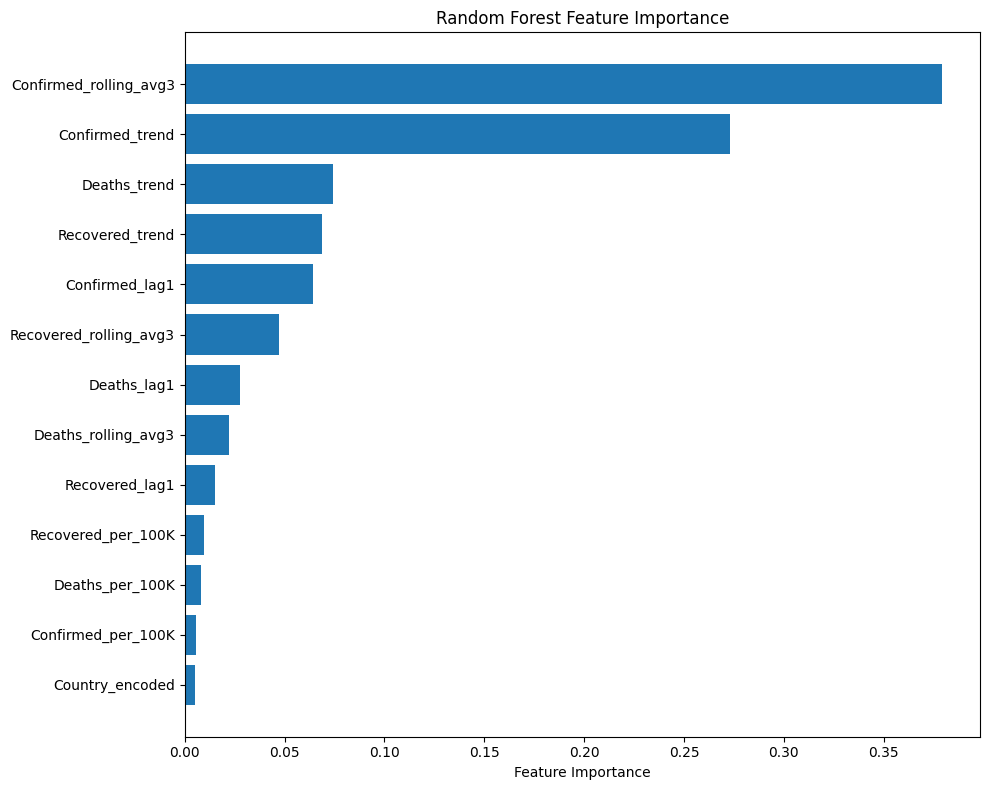

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics for each target
target_names = ['Confirmed', 'Deaths', 'Recovered']
metrics = {'RMSE': [], 'R2': []}

for i, target in enumerate(target_names):
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    metrics['RMSE'].append(rmse)
    metrics['R2'].append(r2)

# Create a figure with proper subplot arrangement
plt.figure(figsize=(15, 12))

# Heatmap 1: RMSE
plt.subplot(3, 2, 1)  # 3 rows, 2 columns, position 1
sns.heatmap(np.array([metrics['RMSE']]), 
            annot=True, fmt=".2f", cmap="YlOrRd",
            xticklabels=target_names, yticklabels=['RMSE'])
plt.title("RMSE by Target Variable")

# Heatmap 2: R²
plt.subplot(3, 2, 2)  # 3 rows, 2 columns, position 2
sns.heatmap(np.array([metrics['R2']]), 
            annot=True, fmt=".4f", cmap="YlGn",
            xticklabels=target_names, yticklabels=['R²'])
plt.title("R² Score by Target Variable")

# Actual vs Predicted plots
for i, target in enumerate(target_names):
    plt.subplot(3, 2, i+3)  # Positions 3, 4, 5 in the grid
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.3)
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
             [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'k--')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'{target}: Actual vs Predicted')

plt.tight_layout()
plt.show()

# Feature Importance (separate figure)
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Couche d'entrée
inputs = Input(shape=(X_train_scaled.shape[1],))

# Couches partagées
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)

# Sorties nommées explicitement
output_confirmed = Dense(1, name='Confirmed')(x)
output_deaths = Dense(1, name='Deaths')(x)
output_recovered = Dense(1, name='Recovered')(x)

# Création du modèle
model = Model(inputs=inputs, outputs=[output_confirmed, output_deaths, output_recovered])

# Compilation avec les noms de sortie alignés
model.compile(
    optimizer='adam',
    loss={'Confirmed': 'mse', 'Deaths': 'mse', 'Recovered': 'mse'},
    metrics={'Confirmed': 'mae', 'Deaths': 'mae', 'Recovered': 'mae'}
)

# Entraînement
history = model.fit(
    X_train_scaled,
    {'Confirmed': y_train['Confirmed'], 'Deaths': y_train['Deaths'], 'Recovered': y_train['Recovered']},
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/150
27/27 [==============================] - 1s 11ms/step - loss: 14597186560.0000 - Confirmed_loss: 11863037952.0000 - Deaths_loss: 41382328.0000 - Recovered_loss: 2692764672.0000 - Confirmed_mae: 22288.0879 - Deaths_mae: 1168.4928 - Recovered_mae: 10981.9355 - val_loss: 51152060416.0000 - val_Confirmed_loss: 32650194944.0000 - val_Deaths_loss: 64696276.0000 - val_Recovered_loss: 18437167104.0000 - val_Confirmed_mae: 32209.9531 - val_Deaths_mae: 1653.3860 - val_Recovered_mae: 21447.4980
Epoch 2/150
27/27 [==============================] - 0s 3ms/step - loss: 14597002240.0000 - Confirmed_loss: 11862897664.0000 - Deaths_loss: 41384028.0000 - Recovered_loss: 2692720384.0000 - Confirmed_mae: 22287.7715 - Deaths_mae: 1168.5443 - Recovered_mae: 10981.7422 - val_loss: 51151155200.0000 - val_Confirmed_loss: 32649496576.0000 - val_Deaths_loss: 64701732.0000 - val_Recovered_loss: 18436954112.0000 - val_Confirmed_mae: 32209.3379 - val_Deaths_mae: 1653.4497 - val_Recovered_mae: 21447.2363

In [9]:
# Sauvegarder le résultat
final_df.to_csv('mspr2_dataset.csv', index=False)

print("done")

done
